# Effect on boom misalignment on figure of merit
In this notebook, I investigate what influence a potential misalingment of the boom has on the resolving power of the instrument and on its effective area. The simualtions assume that the structure of the boom itself never crosses te lightpath, i.e. we have a 4-sdied boom that is big enough.

## Caveats

- **These calculations do NOT include a complete mirror model.** In fact, the mirror model used just assumes that the mirror will focus off-axis sources just as well as on-axis sources. That is obviously a simplification. In that sense, the numbers shown below represent an upper limit on the perfomance.
- Focus position. I did not spend a lot of effort to find the best focus position, so some numbers for the resolving power might be underestimated. However, in most cases, improving the focus for one wavelength will make it worse for others.
- Wavelength: All simulations below are done fir a single wavelength only (0.5 keV = 25 Ang). I chose that wavelength because it's in the most imporatant ARCUS bandpass. At this stage, I think that's probably good enough, but let me know if you require a more extensive study for other wavelengths, too.


### How to read this document
This notebook is a format that displays code, plots and other output on the same html page. You can just looks that the plots (some of them are interactive and allow zoming - look for small icons that appear when you mouse cursor is above it) and my explanatory text.

Use the "toggle on/off raw code" button below to display the code to inspect in detail how the plots are made. Please let me know if you find any error or omissions. The plotting and simulations are done in Python but even if you do not use that language, you can probably see which columns or rows of the fits data files I compare in plots.


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from copy import deepcopy
import transforms3d
import transforms3d.euler
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from astropy.utils.metadata import enable_merge_strategies
import astropy
import astropy.table
from astropy.coordinates import SkyCoord
import astropy.units as u

import marxs
from marxs import utils
from marxs.source import PointSource, JitterPointing
from marxs.analysis import resolvingpower_from_photonlist, detected_fraction

import arcus.arcus

INFO:root:Reading configuration data from ['/nfs/cxc/h2/guenther/.astropy/config/arcus.cfg']
INFO:root:data files in /melkor/d1/guenther/projects/ARCUS/caldb-inputdata: version hash: 7a32fdd - commited on 2017-06-08 17:13:30 -0400

INFO:root:Loading data from spos/petallayout
INFO:root:Loading data from spos/geometricthroughput
INFO:root:Loading data from spos/reflectivity_simple
INFO:root:Loading data from other/pointingjitter
INFO:root:Loading data from gratings/efficiency
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from filters/sifilter
INFO:root:Loading data from filters/opticalblocking
INFO:root:Loading data from filters/uvblocking
INFO:root:Loading data from detectors/contam
INFO:root:Loading data from detectors/qe


In [3]:
%matplotlib inline

In [4]:
import marxs.version
import arcus.version
print('MARXS version {} (commit hash: {} from {})'.format(marxs.version.version, marxs.version.githash, marxs.version.timestamp))
print('ARCUS version {} (commit hash: {} from {})'.format(arcus.version.version, arcus.version.githash, arcus.version.timestamp))

MARXS version 1.1.dev559 (commit hash: a4403e04f5f28e144edbe7480b71189e80ab2b8e from 2017-06-02 10:31:43.411653)
ARCUS version 0.0.dev75 (commit hash: 2898be9b8d49c22b4831075d3cd7b5c67c1be525 from 2017-06-14 16:24:46.400374)


In [5]:
# We've loaded most of the data. Now reduce output when stuff is jsut read again and again below. 
import logging
logging.getLogger().setLevel(logging.WARNING)

In [6]:
def move_element(aff, element):
    # If this is a sequence or parallel, recurse down to the leaves
    if hasattr(element, 'elements'):
        for e in element.elements:
            move_element(aff, e)
    else:
        # Some elements are global and don't have to be moved, e.g. GobalEnergyFilter
        if hasattr(element, "pos4d"):
            element.pos4d = np.dot(aff, element.pos4d)


def move_boom(aff, instrument):
    # For three elements of arcus are part of the boom: aper, mirror, gas
    for i in range(3):
        move_element(aff, instrument.elements[i])

In [7]:
n_photons = 5e4
orders = np.arange(-11, 1)

In [8]:
def Aeff_with_16ccds(theta1, theta2, photons, id_col='ccd16'):
    '''
    Parameters
    ----------
    theta1, theta2 : float
        position (in radian) of the centers of the first CCD detectors in each group of 8.
    '''
    elem_args = arcus.arcus.detccdargs.copy()
    elem_args['id_col'] = id_col
    photonfilter = lambda p: np.isfinite(p['probability']) & (p[id_col] >=0)
    det = marxs.design.RowlandCircleArray(rowland=arcus.arcus.rowland_central,
                                          elem_class=marxs.optics.FlatDetector,
                                          elem_args=elem_args, d_element=49.652,
                                          theta=[theta1, theta1 + 0.0585, theta2, theta2 + 0.0585])
    assert len(det.elements) == 16
    # Check if the id_col in question already exists and if so, set to -1
    if id_col in photons.colnames:
        photons[id_col] = -1
    
    return detected_fraction(det(photons), orders, filterfunc=photonfilter)

In [9]:
def rotshift(axis, orders, angles, shifts):
    '''
    Parameters
    ----------
    axis : string
        'y' or 'z'
    orders : np.array
        Orders for which the resolving power is calculated
    angles : `astropy.units.Quantity`
        Rotation angles
    shifts : np.array
        Translation in mm
    '''
    
    respow = np.zeros((angles.shape[0], orders.shape[0]))
    respowm = np.zeros_like(respow)
    aeff = np.zeros_like(respow)
    aeffm = np.zeros_like(respow)
    for i in range(angles.shape[0]):
        R = transforms3d.euler.euler2mat(angles[i].to(u.rad).value, 0, 0, 's{0}xz'.format(axis))
        T = np.zeros(3)
        if axis == 'y':
            T[1] = shifts[i]
        if axis == 'z':
            T[2] = shifts[i]
        # Estimate change in focus
        # Could move detector up to match that or, equivalenty, the boom down.
        # Here, I'll just put that adjustment on the boom because I move that anyway
        # but in practice we will probably be moving the detectors up.
        d_x = np.sqrt(12e3**2 + shifts[i]**2) - 12e3
        T[0] = -d_x
        aff = transforms3d.affines.compose(T, R, np.ones(3))
        
        mission = deepcopy(arcus.arcus.arcus_extra_det)
        move_boom(aff, mission)
        missionm = deepcopy(arcus.arcus.arcus_extra_det_m)
        move_boom(aff, missionm)
    
        # Pointing is offset to make sure spectral trace still hits the detector
        offsetang = - np.arctan(shifts[i] / 12e3) * u.rad
        if axis == 'y':
            mypointing = JitterPointing(coords=SkyCoord(offsetang, angles[i]), jitter=arcus.arcus.jitter_sigma)
        elif axis =='z':
            mypointing = JitterPointing(coords=SkyCoord(angles[i], offsetang), jitter=arcus.arcus.jitter_sigma)
        else:
            raise ValueError('Offset pointing only possible for y and z rotation')
    
        pr = mysource.generate_photons(n_photons / 2)
        pr = mypointing(pr)
        pr = mission(pr)
        res, pos, std = resolvingpower_from_photonlist(pr, orders, filterfunc=lambda x: x['probability'] > 0)
        respow[i, :] = res

        prm = mysource.generate_photons(n_photons / 2)
        prm = mypointing(prm)
        prm = missionm(prm)
        resm, posm, stdm = resolvingpower_from_photonlist(prm, orders, filterfunc=lambda x: x['probability'] > 0)
        respowm[i, :] = resm
        aeff[i, :] = Aeff_with_16ccds(3.1265, 3.2421, pr)
        aeffm[i, :] = Aeff_with_16ccds(3.1265, 3.2421, prm)
    return respow, respowm, aeff, aeffm

In [10]:
def plot_result(res1, res2, aeff1, aeff2, x, xlabel):
    fig = plt.figure(figsize=(12,8))
    axres2 = fig.add_axes([.1, .1, .38, .35])
    axres1 = fig.add_axes([.1, .5, .38, .35])
    axaeff2 = fig.add_axes([.6, .1, .38, .35])
    axaeff1 = fig.add_axes([.6, .5, .38, .35])
    
    axres2.set_xlabel(xlabel)
    axaeff2.set_xlabel(xlabel)
    axres1.set_ylabel('spectral trace 1')
    axres2.set_ylabel('spectral trace 2')
    axres1.set_title('Loss of resolving power')
    axaeff1.set_title('Scaled effective area')
    # find the nominal case used for normalization
    ind0 = np.argmin(np.abs(x))
    # figure out which orders are actually detected
    ind = (aeff1[ind0, :] > 0) | (aeff2[ind0, :] > 0)
    # Or just plot all orders, just in case
    #ind = np.isfinite(aeff1[0, :])
    inds = ind.nonzero()[0]

    
    for ax, data in zip([axres1, axres2], [res1, res2]):
        for j in range(ind.sum()):
            ax.plot(x, data[:, inds[j]]/data[ind0, inds[j]], label=orders[inds[j]])
    for ax, data in zip([axaeff1, axaeff2], [aeff1, aeff2]):
        for j in range(ind.sum()):
            ax.plot(x, data[:, inds[j]], label=orders[inds[j]])            
            
    axres2.legend(title='order', loc=(1.05, 0.1))
    return fig, axres1, axres2, axaeff1, axaeff2

# Error Mode 1: Rotation (tilt of boom)
In this section, I investigate a boom that is slightly rotated about the origin of the [coordiante system used for the ray-trace](http://marxs.readthedocs.io/en/latest/conventions.html#coordinate-system). The ARCUS setup for CAT gratings has two pairs of channels with two different zero order positions and two different spectral traces. One zeroth order is close to the origin of the coordiante system (0,0,0) and the spectral trace falls into increasing z direction. The other zeroths order is at about z=1.25 m and the spectral trace goes in decreasing z direction.

In practice, the boom is probably more likely to unfold with a rotation around the geometrical center of the focal plane, which sits half-way between the two zeroths orders. Instead, I chose rotation around the position of one ot the zeroths orders for these simulations because that gives us two limiting cases: The effect thar boom rotation would have if the center of the rotation is located between the two zeroths orders is going to be between the numbers that I calculate below for spectral trace 1 and 2.

If the boom deployment results in rotation only, the mirror optical axis still points towards the detectors, it is just angled with respect to the nominal optical axis. We need to point with an offset with respect to the nominal optical axis, but the source would still be positioned on the actual mirror optical axis and the actual grating optical axis.

I treat rotation around the y and z axis separately.

In [11]:
mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'), energy=0.5, flux=1.)


## Yaw (rotation around y)
This is the least intrusive case. 

In [12]:
angles = np.arange(-1., 1.1, .1) * u.degree
resyaw, resyawm, aeffyaw, aeffyawm = rotshift('y', orders, angles, np.zeros_like(angles).value)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.1.dev559-py2.7-linux-x86_64.egg/marxs/math/polarization.py:123: RuntimeWarning: invalid value encountered in divide
  s = s / np.linalg.norm(s, axis=1)[:, None]


/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide


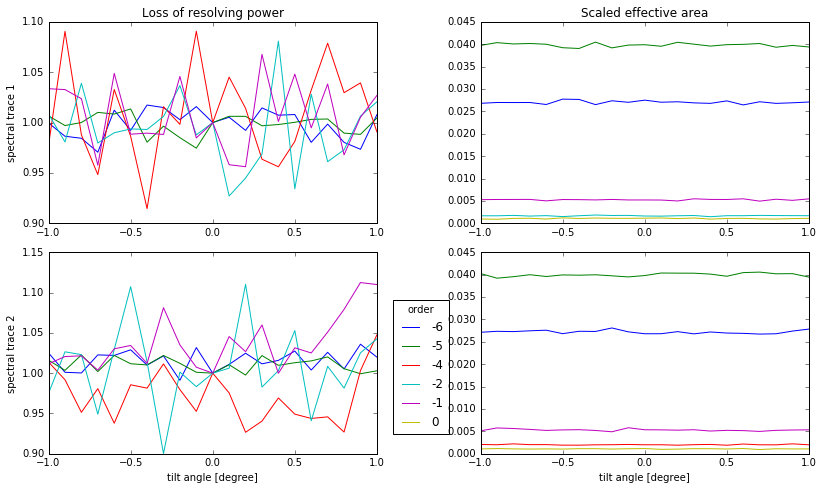

In [13]:
figax = plot_result(resyaw, resyawm, aeffyaw, aeffyawm, angles, 'tilt angle [degree]')

*top and bottom*: There are two spectral traces on the detector, one from each pair of channels. Results are shown separate for both traces.

*left*: Resolving power in different order. For plotting purposes, the resolving power is normalized to the value seen for a nominal boom position to highlight the relative loss of resolving power for larger misalignments. (In general, higher orders give a better resoltuion). In this case the left plots show that even a tilt close to 1 deg does not impact the resolving power. (There is some numeric noise for orders that receive only a small number of photons, which causes significant scatter for some of the curves.) 

*right*: Effective area per order scaled such that 1.0 would mean that the effective area equals the geometric opening area of all SPOs combined.
Since all photons continue to hit almost the same position on the detector, there is also no loss of effective area and the curves on the right are flat for a yaw misalignment.

## Pitch (rotation around z)
I now assume that the boom rotates around the origin of the coordiante system. Thus, one pair of channels keeps pointing at the same position in the (nominal) focal plane and thus the shape of that zeroth order changes very little. However, the CCDs for the dispersed spectrum are placed to follow a Rowland Circle. For CAT gratings, the Rowland Torus is tilted (meaning that the center of the Rowland circle is not on the optical axis) and that means that rotating the boom will place the mirror and gratings at a position that is **not** on the Rowland Circle that the CCDs follow.
(I can make detailed drawings of the geometry if anybody needs them, but at this point it's probably good enough to see the simualted numbers below.)
So (unless we add the capacity to change the tilt of the CCDs in flight) the spectrum will be slightly out of focus. (We can move the detectors up and down to choose which part of the spectrum is in focus, but there is no way to make the focus perfect for the entire spectrum).

For the second pair of channels the situation is more difficult. 

In [14]:
pit = rotshift('z', orders, angles, np.zeros_like(angles).value)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide


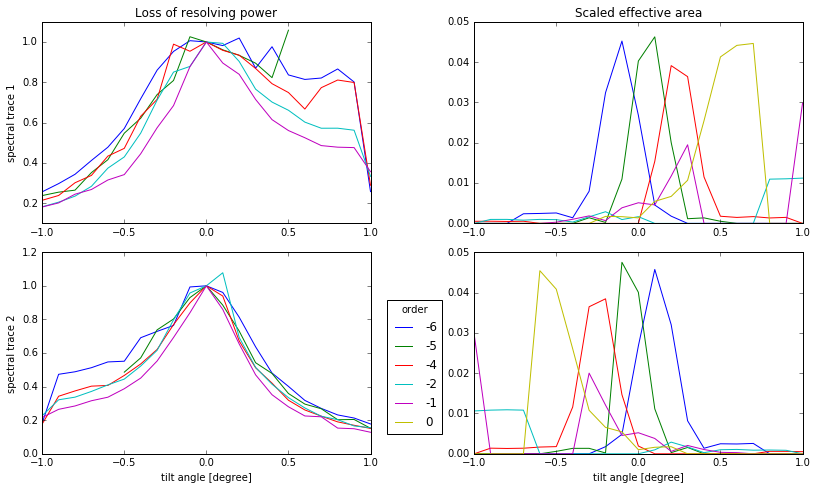

In [15]:
fiax = plot_result(*pit, x=angles, xlabel='tilt angle [degree]')

*left*: The resolving power drops for larger misalignments. At the energy where these simulations are run, most photons are in order -6, which happens to be the order where the resolving power is least effected for spectral trace 1. However, the resolving power drops significantly for the other spectral trace in all orders. If the ARCUS boom deploys with a pitch error like the one simulated here, only one pair of channels can give high resolution data, the other pair becomes essentially a low-res spectrometer.

Note that there is a second effect that reduces the spectral resolving power even further: For larger tilt angles, photons get diffracted into lower orders (see discussion of right plots) and lower orders have intrinsically lower spectral resolving power.

Recall that the simulations assume that the center point of the rotation is close to one of the zeroths orders. If that's not the case, then both pairs of channels will see their resolving power drop significantly for boom tilts above about 0.2 deg.

*right*: As the pitch angle of the boom increases, we need to point more and more off-center to position the spectral traces on the CCD detectors. This changes the blaze angle on the CAT gratings and thus photons get diffracted into different orders. This is fairly easy to see on the top right plot. For the nominal case (no tilt), photons fall into order -6 and -5. For a slight tilt, the number of photons in order -6 drops and the number in -5 increases. As the tilt increases even more, the number of photons in order -5 goes down again and order -4 comes up. The same can be seen in the bottom right plot. 

Because of th tilt, the focal point for spectral trace 2 is not longer on the CCDs. That's why the effective area in the zeroth order rises for large tilts in the upper right plot, but not in the lower right plot.

# Error mode 2: Translation
In this error mode, the boom deploys such that the mirrors and gratings are moved perpendicular to the nominal optical axis. The new actual optical axis is parallel to the nominal optical axis. If we could shift the position of the detectors in the focal plane sideways by as much as mirrors and gratings are displaced sideways we would achieve nominal performance.
If we cannot move the detectors side-ways, we need to offset point so that the zeroth order and the dispersed spectra hit the CCDs. This is the case simulated below. In that case, rays hit mirrors and detectors like and off-axis source and the CAT gratings will be less efficient. (The mirrors will be less efficient, too, but that is not treated in this simulation.) Also, the CCDs will not mathc the Rowland cirlce defined by the gratings any longer, so there is a loss of spectral resolving power in general. The focus can be adjusted to improve the resolving power in some part of the spectrum but there is no way to get the entire spectrum back into focus. As before, I treat displacement in y and z separately.



## Translation in y

In [16]:
np.sqrt(12e3**2+200.**2)

12001.666550941998

In [17]:
trans = np.arange(-100., 101., 10.)
transy = rotshift('y', orders, np.zeros_like(trans) * u.rad, trans)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide


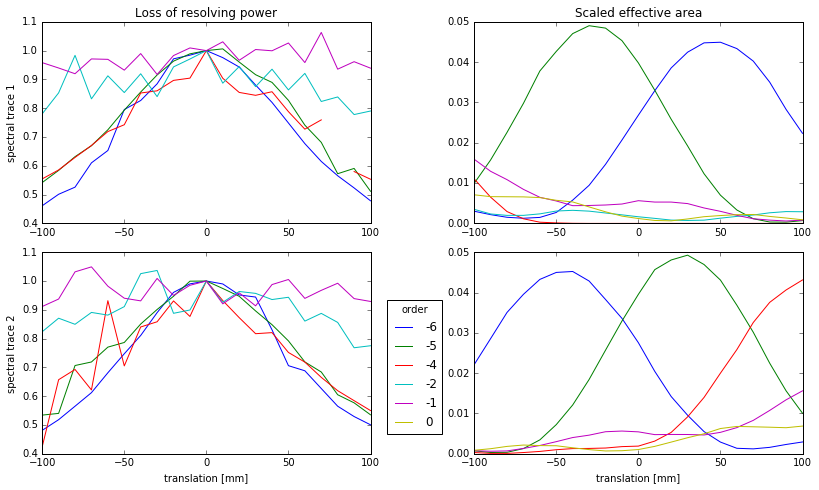

In [18]:
fiax = plot_result(*transy, x=trans, xlabel='translation [mm]')

*left*: In this particular setup the resolving power declines moderately in the relevant orders -6 and -5 for increasing translations. As I said above, my choice of to focus position is somewhat arbitrary; I can improve the focus for some position on the detector (i.e. some wavelengths), but that will make other spetral regions worse. It really comes down to the science case to decide where the best resolution is required. Thus, the numbers for the spectral resolving power should be interpreted qualitatively.

*right*: As we need to point more and more off-center to position the spectral trace on the CCD detectors, the blaze angle for the CAT gratings changes and other orders become effective. Over a fairly large range of displacements, the loss in photons in one order cna be made up by a gain in a different order. However, adding the curves for orders -6 and -5 shows that overall theeffective area decreases for increasing misalignment.

## Translation in z

In [19]:
transz = rotshift('z', orders, np.zeros_like(trans) * u.rad, trans)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide


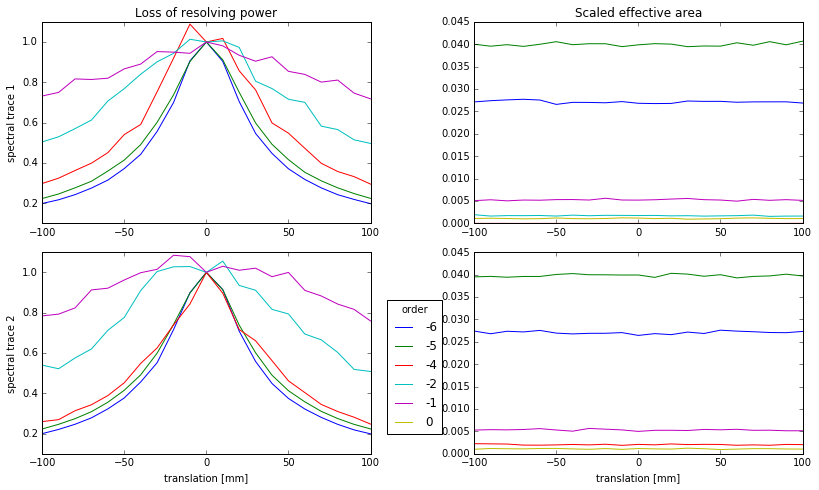

In [20]:
fiax = plot_result(*transz, x = trans, xlabel='translation [mm]')

*left*: As we point more and more off-axis, the focus position needs to be corrected more and more. Finite-size effects for the CAT gratings become more imporant and the resolution decreases. However, in this particular case, I suspect that the resolution can be improved by a better focus position. I can look into that more if needed.

*right*: As the translation increases, we need ot point more and more off-axis, but this happen in the "yaw" direction of the CAT gratings and thus does not influence the grating efficiency. *Remember that in practice the mirror effective area is lower for off-axis pointings, but these simulations do not reproduce that.*

## Notes and code fragments
Below are just some random code fragements that I run interactively to figure out what exactly was going on. I'll keep them here in case I need them later, but they don't mean a lot right now.

In [21]:
shift = 50
ang = 0.

R = transforms3d.euler.euler2mat(np.deg2rad(ang), 0, 0, 'szxz')
T = np.zeros(3)

T[2] = shift
# Estimate change in focus
# Could move detector up to match that or equivalenty, the boom down.
# Here, I'll just put that adjustment on the boom because I move that anyway
# but in practice we will probably be moving the detectors up.
d_x = np.sqrt(12e3**2 + shift**2) - 12e3
T[0] = -d_x
aff = transforms3d.affines.compose(T, R, np.ones(3))
        
mission = deepcopy(arcus.arcus.arcus_extra_det)
move_boom(aff, mission)
missionm = deepcopy(arcus.arcus.arcus_extra_det_m)
move_boom(aff, missionm)
    
# Pointing is offset to make sure spectral trace still hits the detector
offsetang = -np.rad2deg(np.arctan(shift / 12e3))
mypointing = JitterPointing(coords=SkyCoord(0., offsetang, unit='deg'), jitter=arcus.arcus.jitter_sigma)  # z
#mypointing = JitterPointing(coords=(offsetang, 0.), jitter=arcus.jitter_sigma)


In [22]:
pr = mysource.generate_photons(n_photons / 2)
pr = mypointing(pr)
pr = mission(pr)
res, pos, std = resolvingpower_from_photonlist(pr, orders)



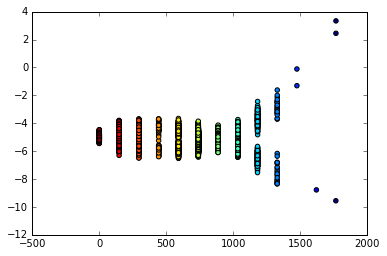

In [31]:
ind = pr['probability'] > 0
plt.scatter(pr['proj_x'][ind], pr['det_y'][ind], c=pr['order'][ind])